In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pykalman import KalmanFilter
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error

In [5]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [27]:
df=pd.read_csv('drive/MyDrive/lab4/Eximbank.csv')
df
df1=df.reset_index()['Close']

In [28]:
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-01-04,7838.982910,7980.226074,7838.982910,7909.604492,7909.604492,136913
1,2016-01-05,7838.982910,7980.226074,7838.982910,7909.604492,7909.604492,298308
2,2016-01-06,7768.361816,7980.226074,7768.361816,7909.604492,7909.604492,377236
3,2016-01-07,7838.982910,7909.604492,7768.361816,7838.982910,7838.982910,298832
4,2016-01-08,7768.361816,7768.361816,7697.740234,7697.740234,7697.740234,424686
...,...,...,...,...,...,...,...
2043,2024-03-14,18200.000000,18200.000000,17900.000000,17950.000000,17950.000000,14772700
2044,2024-03-15,17950.000000,18300.000000,17850.000000,17850.000000,17850.000000,30799500
2045,2024-03-18,17900.000000,18400.000000,17700.000000,18400.000000,18400.000000,30643400
2046,2024-03-19,18450.000000,19000.000000,18300.000000,18600.000000,18600.000000,42471300


In [29]:
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [30]:
train_size = int(0.8 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]

In [31]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [32]:
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest= create_dataset(test_data, time_step)

In [33]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(ytest.shape)



(1537, 100)
(1537,)
(309, 100)
(309,)


In [34]:
kf = KalmanFilter(transition_matrices=[1],
                  observation_matrices=[1],
                  initial_state_mean=X_train[0][0],
                  initial_state_covariance=1,
                  observation_covariance=1,
                  transition_covariance=0.01)

In [35]:
kf = kf.em(X_train[0])

In [36]:
test_data.shape

(410, 1)

In [37]:
test_observed = test_data
test_predicted, _ = kf.filter(test_observed)


In [38]:
test_predicted.shape

(410, 1)

In [39]:
test_predicted=scaler.inverse_transform(test_predicted)
ytest=ytest.reshape(-1,1)
ytest=scaler.inverse_transform(test_data)

In [40]:
test_rmse = np.sqrt(np.mean((test_predicted - ytest)**2))
test_mae = mean_absolute_error(test_predicted, ytest)
test_mape = np.mean(np.abs(test_predicted - ytest)/np.abs(test_predicted))*100

In [41]:
print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)
print('Testing MAE:', test_mae)

Testing RMSE: 496.4802296807703
Testing MAPE: 0.9062641468739517
Testing MAE: 159.5188039998989


In [42]:
x_input=test_data[60:].reshape(1,-1)
x_input.shape[1]

350

In [43]:
test_data[60:].shape

(350, 1)

In [44]:
# 13. Dự báo 30 ngày tiếp theo
x_input=test_data[60:].reshape(1,-1)
print(x_input.shape)

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=x_input.shape[1]
i=0
while(i<30):

    if(len(temp_input)>n_steps):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        #print(x_input)
        yhat, _ = kf.filter(x_input)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat[-1].tolist())
        i=i+1
    else:
        x_input = x_input.reshape(n_steps)
        yhat, _ = kf.filter(x_input)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat[-1].tolist())
        i=i+1

Streaming output truncated to the last 5000 lines.
 [0.52040558]
 [0.51274617]
 [0.50881407]
 [0.51041013]
 [0.51380615]
 [0.5264173 ]
 [0.52620899]
 [0.53620839]
 [0.54377873]
 [0.54768182]
 [0.54607633]
 [0.54555357]
 [0.54538336]
 [0.52375532]
 [0.50664597]
 [0.51258054]
 [0.51882737]
 [0.51654682]
 [0.51580427]
 [0.51412432]
 [0.51357733]
 [0.51339922]
 [0.51621758]
 [0.51713525]
 [0.52031039]
 [0.53141144]
 [0.53790231]
 [0.54001575]
 [0.53926572]
 [0.5332688 ]
 [0.54425977]
 [0.57084924]
 [0.5751923 ]
 [0.56222466]
 [0.56519324]
 [0.56040712]
 [0.57466867]
 [0.58218861]
 [0.57600806]
 [0.57255749]
 [0.57431033]
 [0.56912836]
 [0.55881205]
 [0.55976757]
 [0.54282059]
 [0.5329881 ]
 [0.5254721 ]
 [0.53309211]
 [0.53269684]
 [0.53256814]
 [0.54115529]
 [0.53963675]
 [0.53770414]
 [0.53276035]
 [0.53546517]
 [0.53346952]
 [0.5227525 ]
 [0.51351033]
 [0.51193923]
 [0.51430403]
 [0.50932132]
 [0.51201346]
 [0.5143282 ]
 [0.51508188]
 [0.50813641]
 [0.5087513 ]
 [0.49600794]
 [0.4990495

In [45]:
# Chuyển danh sách thành mảng numpy
values_array = np.array(lst_output)

# Nếu bạn thực sự cần reshape (ví dụ: thành mảng 2D 1 hàng)
values_reshaped = values_array.reshape(-1, 1)

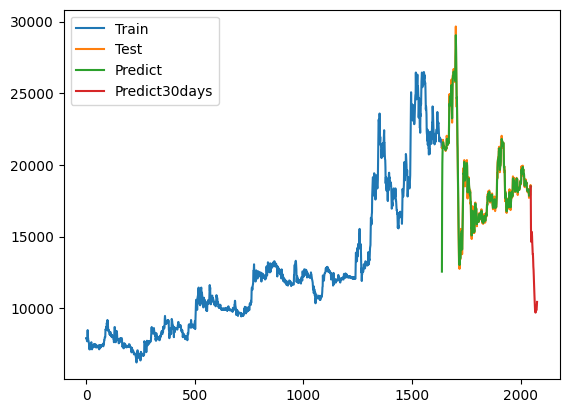

In [46]:
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,test_predicted)

prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(values_reshaped))
plt.legend(['Train','Test','Predict','Predict30days'])
plt.show()

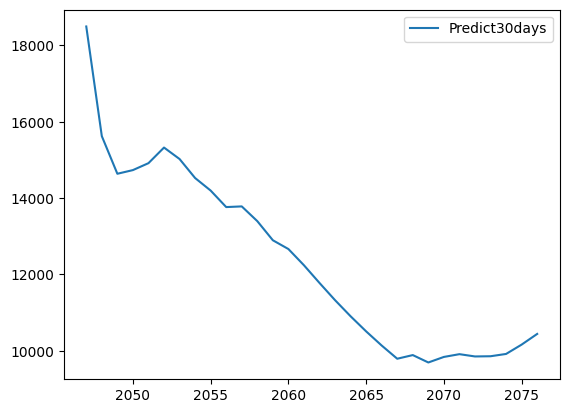

In [47]:
# 14.Vẽ hình
# Dự đoán 30 ngày tiếp theo
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(values_reshaped))
plt.legend(['Predict30days'])
plt.show()